In [40]:
import re
import bz2
import json
import numpy as np
import igraph as ig
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from pymorphy2 import MorphAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.semi_supervised import LabelPropagation
from nltk.tokenize import sent_tokenize, word_tokenize

In [25]:
import warnings
warnings.filterwarnings('ignore')

### Часть 1. Обучение модели Word2Vec

In [2]:
# Загрузка и предобработка данных
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:41, 4815.21it/s]


In [3]:
responses[1]

{'city': 'г. Новосибирск',
 'rating_not_checked': False,
 'title': 'Не могу пользоваться услугой Сбербанк он-лайн',
 'num_comments': 0,
 'bank_license': 'лицензия № 1481',
 'author': 'Foryou',
 'bank_name': 'Сбербанк России',
 'datetime': '2015-06-08 11:09:57',
 'text': 'Доброго дня! Являюсь держателем зарплатной карты , выданной Сбербанком России. В 2008 году сменила фамилию, предоставила в банк \xa0документы (копию нового паспорта, свидетельства о браке), мне перевыпустили карту на фамилию мужа ТОКАРЕВА МАРИЯ АЛЕКСАНДРОВНА (девичья \xa0- СЕКЛЕТИНА). \xa0 Возникла необходимость подключить услугу Сбербанк онлайн, НЕ ПОЛУЧИЛОСЬ (на главной странице на отображались мои карты). Связалась с техническим специалистом отделения Сбербанка в котором обслуживалась. Он пояснил, что в базе банка, я все ещё под девичьей фамилией СЕКЛЕТИНА. Предложил выслать сканы необходимых документов. Выслала, оставив контакты, звонка так и не дождалась. Ч/з некоторое время звоню сама, объясняю ситуацию, меня про

#### _1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова_

In [46]:
# Инициализация объектов, необходимых для работы функции
morph = MorphAnalyzer()
stop_words = set(stopwords.words('russian'))
add_stopwords = 'которых которые твой которой которого сих ком свой твоя этими слишком нами всему будь саму чаще ваше сами наш затем еще ещё самих наши ту каждое мочь весь этим наша своих оба который зато те этих вся ваш такая теми ею которая нередко каждая также чему собой самими нем вами ими откуда такие тому та очень сама нему алло оно этому кому тобой таки твоё каждые твои мой нею самим ваши ваша кем мои однако сразу свое своё ними всё неё тех хотя всем тобою тебе одной другие этао само эта буду самой моё своей такое всею будут своего кого свои мог нам особенно её самому наше кроме вообще вон мною никто это'.split()
stop_words.update(add_stopwords)

In [56]:
# Запишем функцию для обработки текста
def preprocess_response(response):
    sentences = sent_tokenize(response)
    processed_sentences = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        lemmatized_words = [
            morph.parse(word.lower())[0].normal_form
            for word in words if word.isalpha() and re.match('^[а-яА-ЯёЁ]+$', word) and word.lower() not in stop_words
        ]
        processed_sentences.append(lemmatized_words)
    return processed_sentences

In [77]:
print(len(responses))

153499


В целях ускорения работы кода, а также в силу ограниченности ОЗУ, будем выполнять работу на части данных, принимая (понимая)  некоторое снижение итогового качества.

In [67]:
all_sentences = []
for response in tqdm(responses[:30000]):
    sentences = preprocess_response(response['text'])
    all_sentences.extend(sentences)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [11:39<00:00, 42.87it/s]


In [68]:
all_sentences[1]

['являться',
 'клиент',
 'банк',
 'поручитель',
 'кредитный',
 'договор',
 'являться',
 'другой',
 'лицо',
 'письменно',
 'оформить',
 'отношение',
 'банк',
 'повод',
 'урегулирование',
 'задолженность']

#### _2. Обучите по коллекции предложений Word2Vec_

In [69]:
%%time
model = Word2Vec(all_sentences, vector_size=100, window=5, min_count=2, workers=4)

CPU times: total: 35.6 s
Wall time: 10.7 s


In [4]:
# model.save('word2vec.model')
model = Word2Vec.load('word2vec.model')

#### _3. Приведите несколько удачных и неудачных примеров решения стандартных тестов для Word2Vec_

In [8]:
# Тест на определение ближайших слов
print(model.wv.most_similar('банк')[:3])

[('сбербанк', 0.48448967933654785), ('росбанк', 0.4436604380607605), ('мкб', 0.4113754332065582)]


In [19]:
# Тест на определение ближайших слов
print(model.wv.most_similar('женщина')[:3])

[('мужчина', 0.9054936766624451), ('дама', 0.8408928513526917), ('девица', 0.8040528893470764)]


In [31]:
# Тест на аналогии
print(model.wv.most_similar(positive=['женщина', 'король'], negative=['мужчина'], topn=1))

[('мордашка', 0.7164130210876465)]


In [11]:
# Тест на определение лишнего слова
print(model.wv.doesnt_match(['банк', 'офис', 'кредит', 'карта']))

офис


In [10]:
# Тест на определение лишнего слова
print(model.wv.doesnt_match(['яблоко', 'груша', 'апельсин', 'стол']))

стол


In [12]:
# Тест на определение лишнего слова
print(model.wv.doesnt_match(['сбербанк', 'втб', 'альфа-банк', 'яблоко']))

яблоко


#### _4. Постройте несколько визуализаций_

##### TSNE для топ-100 слов

In [20]:
# Найдём топ-100 слов из обученной модели Word2Vec
top_words = model.wv.index_to_key[:100]

In [21]:
# Получаем соответствующие векторы
top_word_vectors  = [model.wv[word] for word in top_words]

In [22]:
# Снижение размерности векторов для визуализации
tsne = TSNE(n_components=2, perplexity=5, verbose=0, random_state=42)
word_vectors_tsne = tsne.fit_transform(np.array(top_word_vectors ))

In [26]:
# Кластеризуем полученные двумерные данные
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(word_vectors_tsne)

In [27]:
# Создаем DataFrame для визуализации
df = pd.DataFrame(word_vectors_tsne, index=top_words, columns=['x', 'y'])
df['cluster'] = clusters

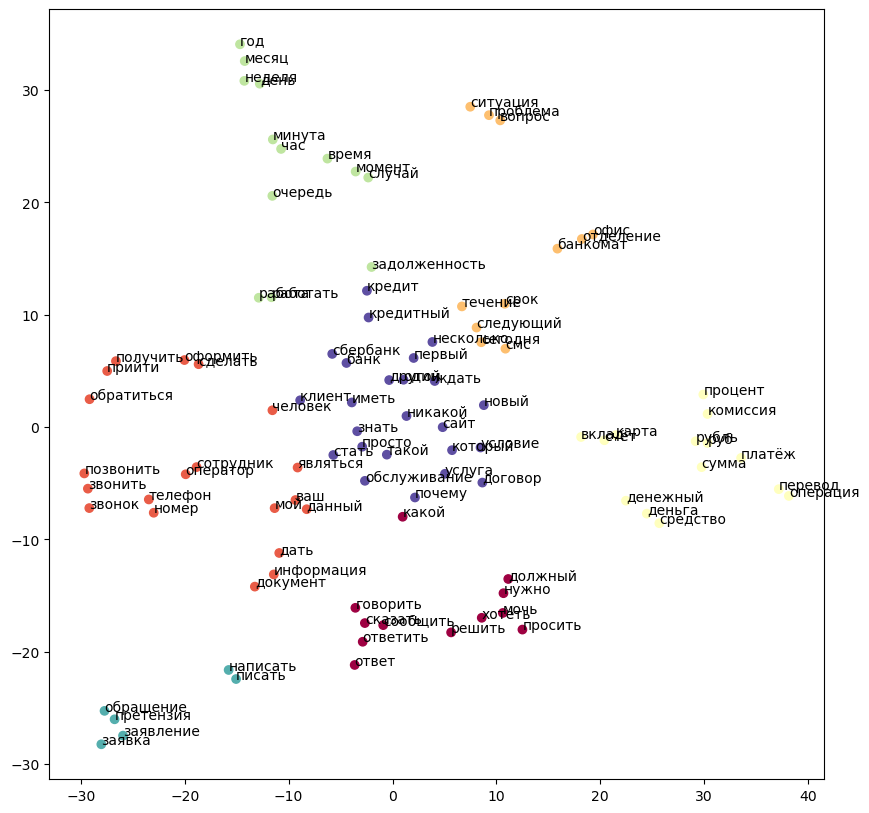

In [35]:
# Рисуем график
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(df['x'], df['y'], c=df['cluster'], cmap='Spectral')

# Добавляем аннотации для каждого слова
for word, pos in df[['x', 'y']].iterrows():
    ax.annotate(word, pos)

plt.show()

##### Нахождение координат названий банков в новом пространстве

In [59]:
# Названия банков для примера
banks = ['сбербанк', 'альфабанк', 'втб', 'райффайзенбанк', 'тинькофф', 'гпб']

In [48]:
# Зададим оси нового пространства
bad_good_vector = model.wv['плохой'] - model.wv['хороший']
slow_fast_vector = model.wv['медленный'] - model.wv['быстрый']

In [49]:
bank_coordinates = {}
for bank in banks:
    bank_vector = model.wv[bank]
    x = np.dot(bank_vector, bad_good_vector)
    y = np.dot(bank_vector, slow_fast_vector)
    bank_coordinates[bank] = (x, y)

print(bank_coordinates)

{'сбербанк': (-8.105206, -3.211454), 'альфабанк': (-0.12791568, 1.2634187), 'втб': (-9.100735, 8.099783), 'райффайзенбанк': (-4.0342264, 4.263358), 'тинькофф': (-16.203259, -4.152462), 'гпб': (-0.5765746, 2.1096888)}


In [64]:
# Создаем DataFrame для визуализации
df_coords = pd.DataFrame.from_dict(bank_coordinates, orient='index', columns=['x', 'y'])

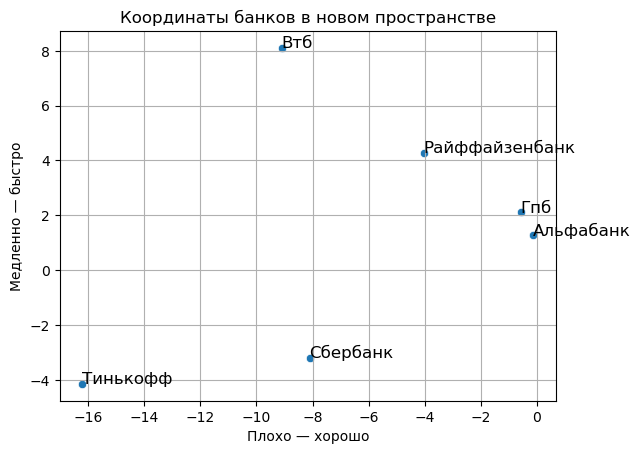

In [67]:
# Визуализация координат банков
sns.scatterplot(x='x', y='y', data=df_coords)

for bank in df_coords.index:
    plt.text(df_coords.x[bank], df_coords.y[bank], bank.capitalize(), fontsize=12)

plt.xlabel('Плохо — хорошо')
plt.ylabel('Медленно — быстро')
plt.title('Координаты банков в новом пространстве')
plt.grid(True)
plt.show()

### Часть 2. Распространить метки.

In [78]:
# Предполагаемые позитивные и негативные слова
positive_words = ['быстрый', 'удобный', 'вежливый', 'отличный', 'прекрасный']
negative_words = ['медленный', 'неудобный', 'грубый', 'плохой', 'ужасный']

In [79]:
# Создание графа
g = ig.Graph(directed=True)
vertices = set()
edges = []

In [80]:
for word in model.wv.index_to_key:
    vertices.add(word)
    similar_words = model.wv.most_similar(word, topn=5)
    for sim_word, sim_val in similar_words:
        edges.append((word, sim_word, sim_val))

In [81]:
# Добавление вершин и рёбер в граф
g.add_vertices(list(vertices))
g.add_edges([(edge[0], edge[1]) for edge in edges])
g.es['weight'] = [edge[2] for edge in edges]

In [82]:
# Подготовка данных для Label Propagation
labels_index = {word: idx for idx, word in enumerate(g.vs['name'])}
y = np.array([-1] * len(g.vs))
for word in positive_words:
    y[labels_index[word]] = 1
for word in negative_words:
    y[labels_index[word]] = 0

In [83]:
%%time
# Label Propagation
label_prop_model = LabelPropagation(kernel='knn', n_neighbors=5, max_iter=1000)
label_prop_model.fit(g.get_adjacency().data, y)
labels = label_prop_model.transduction_

CPU times: total: 19min 9s
Wall time: 4min 35s


In [84]:
# Результаты распространения меток
predicted_labels = {word: labels[idx] for word, idx in labels_index.items() if labels[idx] != -1}

In [87]:
# Вывод новых классифицированных слов
new_positive_words = [word for word, label in predicted_labels.items() if label == 1]
new_negative_words = [word for word, label in predicted_labels.items() if label == 0]

print("Новые позитивные слова:", new_positive_words[:3])
print("Новые негативные слова:", new_negative_words[:3])

Новые позитивные слова: ['удобный', 'вполне', 'терпеливо']
Новые негативные слова: ['будка', 'конский', 'сумаидти']


Несколько неоднозначный результат, но, тем не менее.